# Stellar Object Classification: Galaxies, Stars, and Quasars

This Jupyter Notebook documents the process of building a model to classify stellar objects into three categories: galaxies, stars, and quasars. The dataset used in this project contains information about the objects' positions in the sky, magnitudes in different wavelengths, redshifts, and their corresponding classes. A SQL Query yielded over 2 million observations of stellar objects from the Sloan Digital Sky Survey SkyServerDR9 and the RandomForestClassifier assigned the accurate class to unseen data 99% of the time.

The notebook includes the following sections:

## Data Exploration and Preprocessing
This section focuses on exploring the dataset and performing necessary preprocessing steps. It covers importing libraries, examining the dataset's structure, handling missing values, filtering out invalid data, and converting categorical variables into numerical representations.

## Redshift Analysis 1
In this section, the redshifts of different stellar objects are analyzed and visualized using histograms. Separate histograms are created for galaxies, stars, and quasars to observe the distribution of redshift values within each class.

## Random Forest Classification
This section covers training a random forest classifier using the preprocessed dataset. The features used for classification include the object's position, magnitudes in different wavelengths, and redshift. The dataset is balanced using the SMOTE technique to address the class imbalance issue.

## Model Evaluation
The trained random forest classifier is evaluated using various metrics such as accuracy, precision, recall, and F1-score. A confusion matrix is also generated to visualize the performance of the classifier in predicting the correct class for each object.

## Feature Importance
This section determines the importance of each feature in the classification task using the feature_importances_ attribute of the random forest classifier. The importance values are sorted in descending order to identify the most influential features.

## Error Analysis
Misclassified objects are identified by comparing the predicted classes with the true classes. The misclassified objects, along with their predicted and true classes, are stored in a dataframe for further analysis. Histograms are plotted to visualize the redshift distribution of misclassified objects for each class.

## Conclusion
* Without knowing any laws of physics, the model predicted the class of 551,506 stellar objects {Galaxy: 0, Star: 1, Quasar:2} correctly for 544,944 of the objects.
* I documented several objects that have a change in classification and am curious when none of the other data changes in my query except for the class, what is the root cause of that?
* Making better use of the position in the sky may prove useful when taking into account gravitational redshift and other relativistic effects.
* This is a big dataset to train and I am weary to try hyperparameter tuning in this case but it may improve the model. 
* Removing the 'objid' from the dataframe may marginally increase performance but it was useful for me to look at the real images the of the tough objects to classify


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
# from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Retrieving **all** the data
##### This file is far too large (346 MB) to share but I'll share the next best thing and teach you how to download it yourself! Take care not to abuse it! SDSS SkyServer is an incredible resource! 

[SDSS SkyServer](https://skyserver.sdss.org/dr9/en/tools/search/sql.asp)
* This query does a table JOIN between the imaging (PhotoObj) and spectra (SpecObj) tables and includes the necessary columns in the SELECT to upload the results to the SAS (Science Archive Server) for FITS file retrieval.
```
SELECT TOP 10
    p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
    p.run, p.rerun, p.camcol, p.field,
    s.specobjid, s.class, s.z as redshift,
    s.plate, s.mjd, s.fiberid
 FROM PhotoObj AS p
    JOIN SpecObj AS s ON s.bestobjid = p.objid
 WHERE 
    p.u BETWEEN 0 AND 19.6
    AND g BETWEEN 0 AND 20
```

In [3]:
star = pd.read_csv('data/stars_larger_2.csv',header=0)
star.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237645943434969150,40.279741,0.563509,18.41223,17.24312,17.35328,17.44520,17.54572,109,301,5,37,3519736912225083392,STAR,0.000315,3126,54804,632
1,1237645943435034680,40.384888,0.437542,23.95274,21.32203,19.64270,18.06598,17.26149,109,301,5,38,459520849293109248,STAR,-0.000079,408,51821,559
2,1237648703506285128,190.138527,-0.815252,26.10609,22.13030,20.31503,19.46180,19.07092,752,301,2,311,4333704553519576064,GALAXY,0.457345,3849,55274,421
3,1237648702967644418,186.099244,-1.085694,21.09884,20.30471,20.03852,20.03303,20.20160,752,301,1,284,2891344840430217216,STAR,0.001104,2568,54153,123
4,1237648702967644300,186.114326,-1.078596,20.06134,19.06786,18.90531,18.83770,18.90073,752,301,1,284,2891344290674403328,STAR,0.000619,2568,54153,121


In [4]:
star.shape

(2206175, 18)

In [5]:
star["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in star["class"]]

In [6]:
star['class'].value_counts(normalize=True)

0    0.609363
1    0.286573
2    0.104064
Name: class, dtype: float64

The classes are highly imbalanced with a lot more galaxies, 61%, than quasars, 10%. Quasars occur around galactic black holes that are actively eating and can be brighter than the billions of stars' of a galaxies light combined

In [7]:
star.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [8]:
# Function to convert MJD to datetime
def mjd_to_date(mjd):
    # Reference date for MJD (November 17, 1858)
    ref_date = datetime(1858, 11, 17)
    # Calculate the number of days from the reference date
    days = timedelta(days=mjd)
    # Add the number of days to the reference date
    date = ref_date + days
    # Return the date in MM-DD-YYYY format
    return date.strftime('%m-%d-%Y')
star['date'] = star['mjd'].apply(mjd_to_date)
star.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
0,1237645943434969150,40.279741,0.563509,18.41223,17.24312,17.35328,17.44520,17.54572,109,301,5,37,3519736912225083392,1,0.000315,3126,54804,632,12-04-2008
1,1237645943435034680,40.384888,0.437542,23.95274,21.32203,19.64270,18.06598,17.26149,109,301,5,38,459520849293109248,1,-0.000079,408,51821,559,10-04-2000
2,1237648703506285128,190.138527,-0.815252,26.10609,22.13030,20.31503,19.46180,19.07092,752,301,2,311,4333704553519576064,0,0.457345,3849,55274,421,03-19-2010
3,1237648702967644418,186.099244,-1.085694,21.09884,20.30471,20.03852,20.03303,20.20160,752,301,1,284,2891344840430217216,1,0.001104,2568,54153,123,02-22-2007
4,1237648702967644300,186.114326,-1.078596,20.06134,19.06786,18.90531,18.83770,18.90073,752,301,1,284,2891344290674403328,1,0.000619,2568,54153,121,02-22-2007


In [9]:
# what objects have the likely sensor readings for the five wavelengths?
star[(star['u']<0) | (star['g']<0) | (star['r']<0) | (star['i']<0) | (star['z']<0)].sample(5)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
474547,1237657586030215445,54.461008,0.003397,-9999.00000,-9999.00000,-9999.00000,-9999.0,-9999.0,2820,301,3,230,2970196865598908416,2,2.603785,2638,54095,265,12-26-2006
52676,1237646379377885363,55.114934,-1.263863,19.99068,20.57228,18.34961,-9999.0,-9999.0,211,301,1,94,2970180922680305664,1,-0.000569,2638,54095,207,12-26-2006
9736,1237648704585072825,201.660560,0.215090,-9999.00000,-9999.00000,-9999.00000,-9999.0,-9999.0,752,301,4,388,334520398303488000,0,0.079979,297,51959,466,02-19-2001
9851,1237648705135706425,233.038271,0.635701,-9999.00000,-9999.00000,-9999.00000,-9999.0,-9999.0,752,301,5,598,408836114850277376,0,0.135280,363,51989,489,03-21-2001
505244,1237657587101728809,49.405459,0.842626,-9999.00000,-9999.00000,-9999.00000,-9999.0,-9999.0,2820,301,5,196,905336538273966080,1,0.000039,804,52286,411,01-12-2002


## Taking a look at image of 1237648702973673741 resulted in my discovery of the flags:
![alt text](https://github.com/seanhulseman/stellar-object-classification---larger-attempt/blob/main/imgs/flagged%20galaxy%20closer%20look.png)
* **TOO_FEW_GOOD_DETECTIONS**
* **BINNED1** - Possible means data points are grouped together to attempt to improve the quality
* **INTERP** - Interpolation of some points may mean spectra is incomplete
* **NOPETRO** - Petrosian Magnitudes? "For galaxy photometry, measuring flux is more difficult than for stars, because galaxies do not all have the same radial surface brightness profile, and have no sharp edges. In order to avoid biases, we wish to measure a constant fraction of the total light, independent of the position and distance of the object....In practice, there are a number of complications associated with this definition, because noise, substructure, and the finite size of objects can cause objects to have no Petrosian radius, or more than one."
* **EDGE** - Objects near the edge of a survey are unreliable due to various observational biasis

## and Quasar 1237657585493606729:
![alt text](https://github.com/seanhulseman/stellar-object-classification---larger-attempt/blob/main/imgs/flagged%20quasar%20closer%20look.png)
* **STATIONARY**
* **TOO_FEW_DETECTIONS**
* **NODEBLEND_MOVING**
* **MOVED**
* **BINNED1**
* **MANYPETRO** 
* **NOPETRO**
* **EDGE**

## Drop -9999's
##### A -9999 value is used to indicate missing data. Much of the data is interpolated, blended with multiple images, containing noise from other objects and the gravitational effects on bending light. I decided to filter all -9999 values before modeling.


In [10]:
star = star[star['z']>0]
star = star[star['i']>0]
star = star[star['r']>0]
star = star[star['g']>0]
star = star[star['u']>0]
star.shape

(2206027, 19)

##### How many duplicate ids are there and what are the objects? 

In [11]:
star[star['objid'].duplicated(keep=False)].sort_values('objid').shape

(102, 19)

### 51 duplicates 

### only 4 objects out of the more than 2 million changed class with future observations. 
##### 3/4 of those have same spectral information but increased redshifts. Also, the full interactive spectra appear to different spectra altogether. I dont trust the earlier observation of these objects and will drop them before modeling.

In [12]:
# did any other duplicated obj id change class?
duplicated_objects = star[star['objid'].duplicated(keep=False)]
# duplicated_objects.sort_values(['objid','mjd','class'])
class_changed = duplicated_objects[duplicated_objects.groupby('objid')['class'].transform('nunique') > 1]
class_changed.sort_values(['objid','mjd'])


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
145707,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,548405371329341440,2,0.139731,487,51943,335,02-03-2001
214316,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,2013112132052215808,0,0.139041,1788,54468,11,01-03-2008
545336,1237658424624677935,153.268087,7.180763,25.18145,25.14244,23.54615,20.51345,18.62344,3015,301,5,262,1121564027047143424,1,-0.000108,996,52641,610,01-02-2003
799411,1237658424624677935,153.268087,7.180763,25.18145,25.14244,23.54615,20.51345,18.62344,3015,301,5,262,5489032620962935808,2,0.429574,4875,55677,984,04-26-2011
1257808,1237661852022472838,232.243609,35.029149,20.56634,18.09183,16.82528,16.25343,15.87566,3813,301,5,474,1524630149285308416,1,-0.000178,1354,52814,588,06-24-2003
835854,1237661852022472838,232.243609,35.029149,20.56634,18.09183,16.82528,16.25343,15.87566,3813,301,5,474,1577468010728286208,0,0.194904,1401,53144,299,05-19-2004
1209568,1237666301628711158,48.860987,0.825905,23.14047,22.98053,23.05058,20.94145,20.93315,4849,301,5,781,1200379218676967424,1,-0.000586,1066,52589,618,11-11-2002
1184842,1237666301628711158,48.860987,0.825905,23.14047,22.98053,23.05058,20.94145,20.93315,4849,301,5,781,1705830767034132480,0,0.683108,1515,52932,336,10-20-2003


In [13]:
# this one here: 1237651540315930774 is a quasar that later was observed and classified to be a galaxy
star[star['objid']==1237651540315930774]

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid,date
145707,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,548405371329341440,2,0.139731,487,51943,335,02-03-2001
214316,1237651540315930774,146.923289,63.660914,20.14895,17.90844,16.75519,16.21467,15.78975,1412,301,6,63,2013112132052215808,0,0.139041,1788,54468,11,01-03-2008


#### the above object can be examined more closely via SDSS skyserver query 
#### initially this was a Quasar MJD 51943 is 02-03-2001
![QSO to Galaxy closer look 2.png](<attachment:QSO to Galaxy closer look 2.png>)
![alt text](https://github.com/seanhulseman/stellar-object-classification---larger-attempt/blob/main/imgs/QSO%20to%20Galaxy%20closer%20look%202.png)
###### FLAGS: DEBLEND_DEGENERATE DEBLENDED_AT_EDGE STATIONARY BINNED1 INTERP COSMIC_RAY CHILD
#### The same object is later a Galaxy MJD 54468 is 01-03-2008
![alt text](https://github.com/seanhulseman/stellar-object-classification---larger-attempt/blob/main/imgs/QSO%20to%20Galaxy%20closer%20look%201.png)
###### FLAGS: DEBLEND_DEGENERATE DEBLENDED_AT_EDGE STATIONARY BINNED1 INTERP COSMIC_RAY CHILD
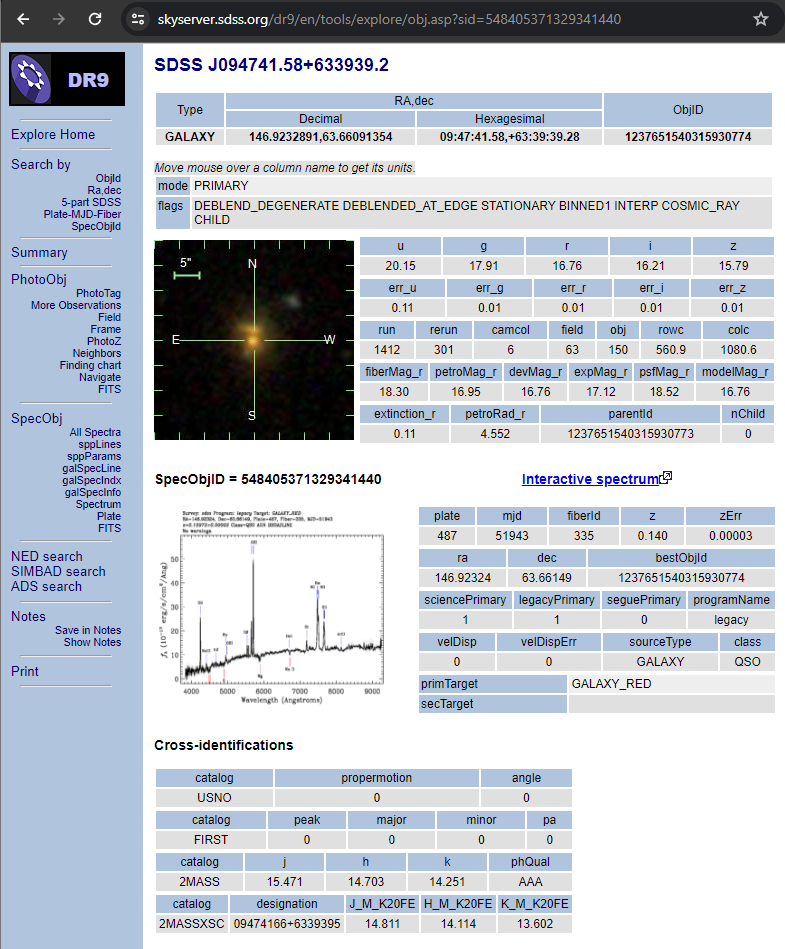

In [14]:
# manually dropping these as they are contradictory to future observations
s_id_drop = [548405371329341440,1121564027047143424,1524630149285308416,1200379218676967424]
# droppings those specobjid from the dataset
star = star[~star['specobjid'].isin(s_id_drop)]
star.shape

(2206023, 19)

### Did the paradigm shift or did the quasar event come to an end?

## Let's Explore Redshift

In [15]:
qso_df = star[star['class']==2]
star_df = star[star['class']==1]
galaxy_df = star[star['class']==0]

In [16]:
qso_df.shape , star_df.shape, galaxy_df.shape

((229563, 19), (632173, 19), (1344287, 19))

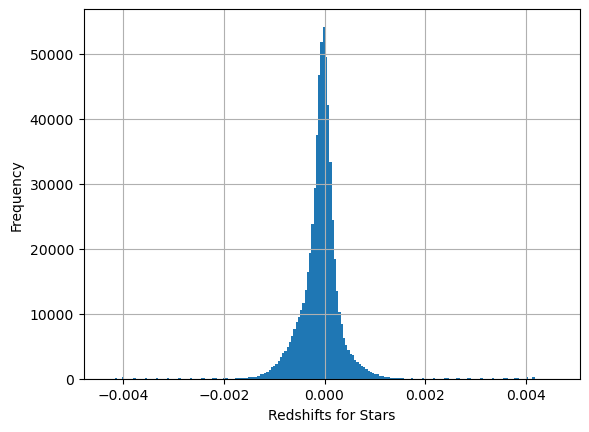

In [17]:
star_df.redshift.hist(bins=200)
plt.xlabel('Redshifts for Stars')
plt.ylabel('Frequency')
plt.savefig('imgs/star_redshifts.png');

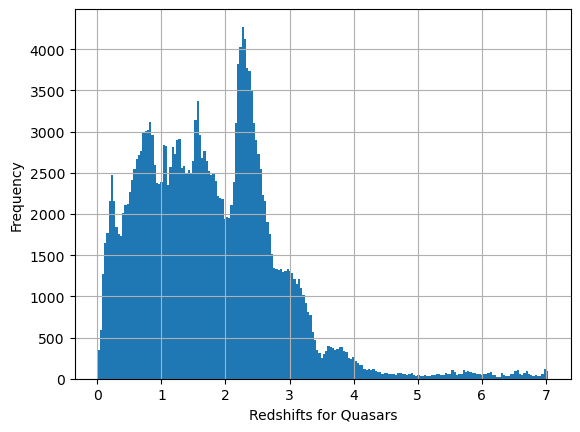

In [18]:
qso_df.redshift.hist(bins=200)
plt.xlabel('Redshifts for Quasars')
plt.ylabel('Frequency')
plt.savefig('imgs/quasar_redshifts.png');

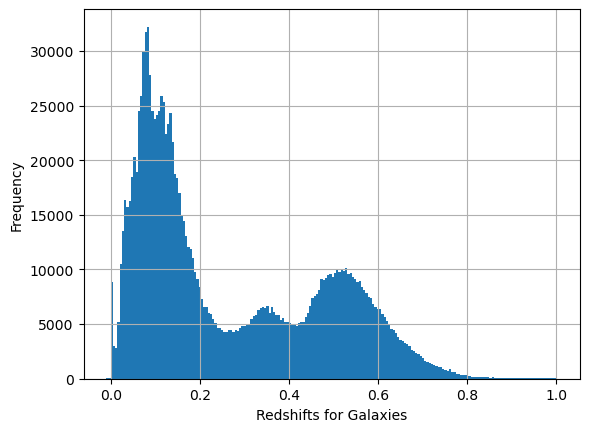

In [19]:
galaxy_df.redshift.hist(bins=200)
plt.xlabel('Redshifts for Galaxies')
plt.ylabel('Frequency')
plt.savefig('imgs/galaxy_redshifts.png');

### A random forest model should be a good start.
##### I will use the wavelength information and redshift, the position in the sky 'ra' and 'dec', and for now I want be sure not to lose the objid as I want to analyze the misclassifications further using the SDSS skyserver.

In [20]:
star_spect_df = star[['ra','dec','objid','u','g','r','i','z','class','redshift']] 
# objid is not needed for the model but I want it for later error analysis via SkyServer. 
# Hopefully the random forest model will still do fine.

In [21]:
star_spect_df.head()

,ra,dec,objid,u,g,r,i,z,class,redshift
0,40.279741,0.563509,1237645943434969150,18.41223,17.24312,17.35328,17.44520,17.54572,1,0.000315
1,40.384888,0.437542,1237645943435034680,23.95274,21.32203,19.64270,18.06598,17.26149,1,-0.000079
2,190.138527,-0.815252,1237648703506285128,26.10609,22.13030,20.31503,19.46180,19.07092,0,0.457345
3,186.099244,-1.085694,1237648702967644418,21.09884,20.30471,20.03852,20.03303,20.20160,1,0.001104
4,186.114326,-1.078596,1237648702967644300,20.06134,19.06786,18.90531,18.83770,18.90073,1,0.000619


In [22]:
Xs = star_spect_df.drop(columns=['class'])
ys = star_spect_df['class']

In [23]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,ys,random_state=512)

In [40]:
Xs_test.shape

(551506, 9)

## SMOTE - Synthetic Minority Oversampling Technique 
##### Creates artificial members of the underrepresented classes. This should be a way to ensure my model does not default on guessing galaxy, the most common class.

In [24]:
sm = SMOTE(random_state=512)
print('Original dataset shape %s' % Counter(ys_train))
Xs_train, ys_train = sm.fit_resample(Xs_train, ys_train)
print('Resampled dataset shape %s' % Counter(ys_train))

Original dataset shape Counter({0: 1008465, 1: 474085, 2: 171967})


Resampled dataset shape Counter({0: 1008465, 1: 1008465, 2: 1008465})


In [25]:
# make a standard random forest classifier
rf = RandomForestClassifier(n_jobs = 4)
rf.fit(Xs_train, ys_train)
rf.score(Xs_test,ys_test)

0.9881016706980522

In [26]:
print(classification_report(ys_test, rf.predict(Xs_test)))
print(confusion_matrix(ys_test, rf.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    335822
           1       1.00      1.00      1.00    158088
           2       0.95      0.95      0.95     57596

    accuracy                           0.99    551506
   macro avg       0.98      0.98      0.98    551506
weighted avg       0.99      0.99      0.99    551506

[[332020    735   3067]
 [    65 158023      0]
 [  2665     30  54901]]


In [41]:
332020+158023+54901

544944

#### Surface levels observations from classification report and confusion matrix
* the model most easily classifies stars, then galaxies, and performs the worst on Quasars
* 

## What features are most important?

In [27]:
sorted([(rf.feature_importances_[i], rf.feature_names_in_[i]) for i in range(len(rf.feature_names_in_))])

[(0.0028818647969363546, 'objid'),
 (0.005551743531223149, 'dec'),
 (0.008369452355126948, 'ra'),
 (0.04754766267314518, 'r'),
 (0.04816008725465401, 'i'),
 (0.05490978908447139, 'g'),
 (0.058141091353677045, 'u'),
 (0.08313360205190551, 'z'),
 (0.6913047068988604, 'redshift')]

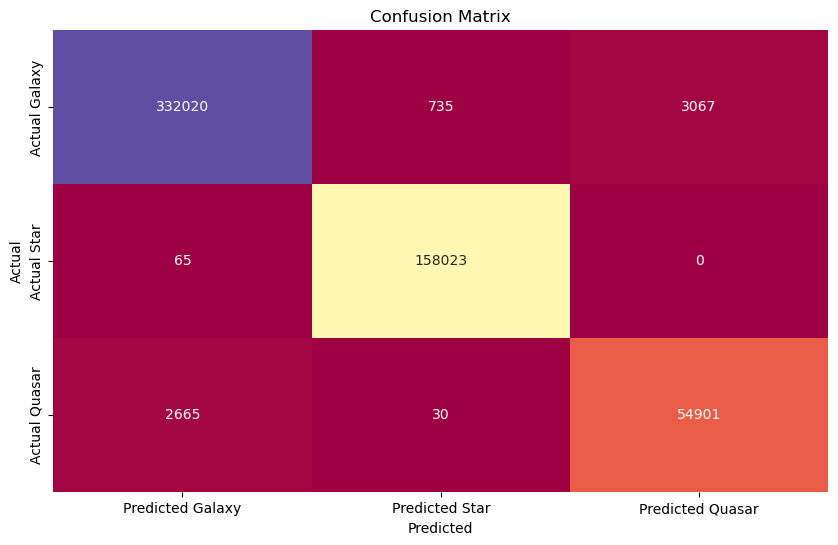

In [28]:
cm = confusion_matrix(ys_test, rf.predict(Xs_test))

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Spectral", cbar=False,
            xticklabels=["Predicted Galaxy", "Predicted Star","Predicted Quasar" ],
            yticklabels=["Actual Galaxy", "Actual Star","Actual Quasar"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('imgs/confusion_matirix.png')
plt.show()

In [29]:
# what are the ids of the stars predicted to be quasars?


In [30]:
# Generate predictions
preds = rf.predict(Xs_test)
# which indices are misclassifications?
mismatched_indices = (preds != ys_test)

# what are the predicted classes for the misclassified objects?
predicted_label = preds[mismatched_indices]
y_true = ys_test[mismatched_indices].reset_index().drop(columns=['index'])['class']
# what are the misclassified objects?
# Making a dataframe with the misclassified objects and their predicted labels
mismatched_objects = Xs_test[mismatched_indices]

In [31]:
mismatched_objects.head()

,ra,dec,objid,u,g,r,i,z,redshift
294541,166.809502,4.069218,1237654600496971907,20.21323,19.85740,19.49941,19.28034,19.10489,0.029256
753343,153.745917,5.597620,1237658298458178199,21.23162,20.29168,19.45468,18.67217,18.14604,0.537663
592781,40.856454,-0.070198,1237657070628110658,21.32052,20.56077,19.90846,19.63691,18.97445,0.355432
648535,259.431804,27.555523,1237655473438262717,22.53007,22.06032,20.93242,19.81999,19.38560,0.635265
50528,51.855095,-6.614422,1237649962992861287,18.64159,17.33790,16.53795,16.04053,15.73990,0.105701


In [32]:
mismatched_objects.reset_index(inplace=True, drop=True)
# mismatched_objects.drop(columns=['index'],inplace=True)
mismatched_objects.head()

,ra,dec,objid,u,g,r,i,z,redshift
0,166.809502,4.069218,1237654600496971907,20.21323,19.85740,19.49941,19.28034,19.10489,0.029256
1,153.745917,5.597620,1237658298458178199,21.23162,20.29168,19.45468,18.67217,18.14604,0.537663
2,40.856454,-0.070198,1237657070628110658,21.32052,20.56077,19.90846,19.63691,18.97445,0.355432
3,259.431804,27.555523,1237655473438262717,22.53007,22.06032,20.93242,19.81999,19.38560,0.635265
4,51.855095,-6.614422,1237649962992861287,18.64159,17.33790,16.53795,16.04053,15.73990,0.105701


In [33]:
mismatched_objects['predicted_class'] = predicted_label
mismatched_objects['true_class'] = y_true

In [34]:
mismatched_objects.sample(5)

,ra,dec,objid,u,g,r,i,z,redshift,predicted_class,true_class
3023,189.994522,-1.309696,1237650372096950584,22.41375,21.27297,20.69259,20.41391,19.93452,0.412068,2,0
2705,180.734442,10.488159,1237658493353394341,20.07925,18.71593,17.75821,17.28344,16.96846,0.165863,0,2
5970,145.514430,-2.156379,1237650804264927602,22.84621,21.67077,21.10414,20.80219,20.47149,0.380763,2,0
5335,120.387397,34.963169,1237657595685307450,23.39299,21.71811,20.79833,19.96881,19.62969,0.632688,0,2
335,128.080258,16.061416,1237667293184525203,22.02231,21.13562,20.14100,19.35731,19.73474,0.714193,2,0


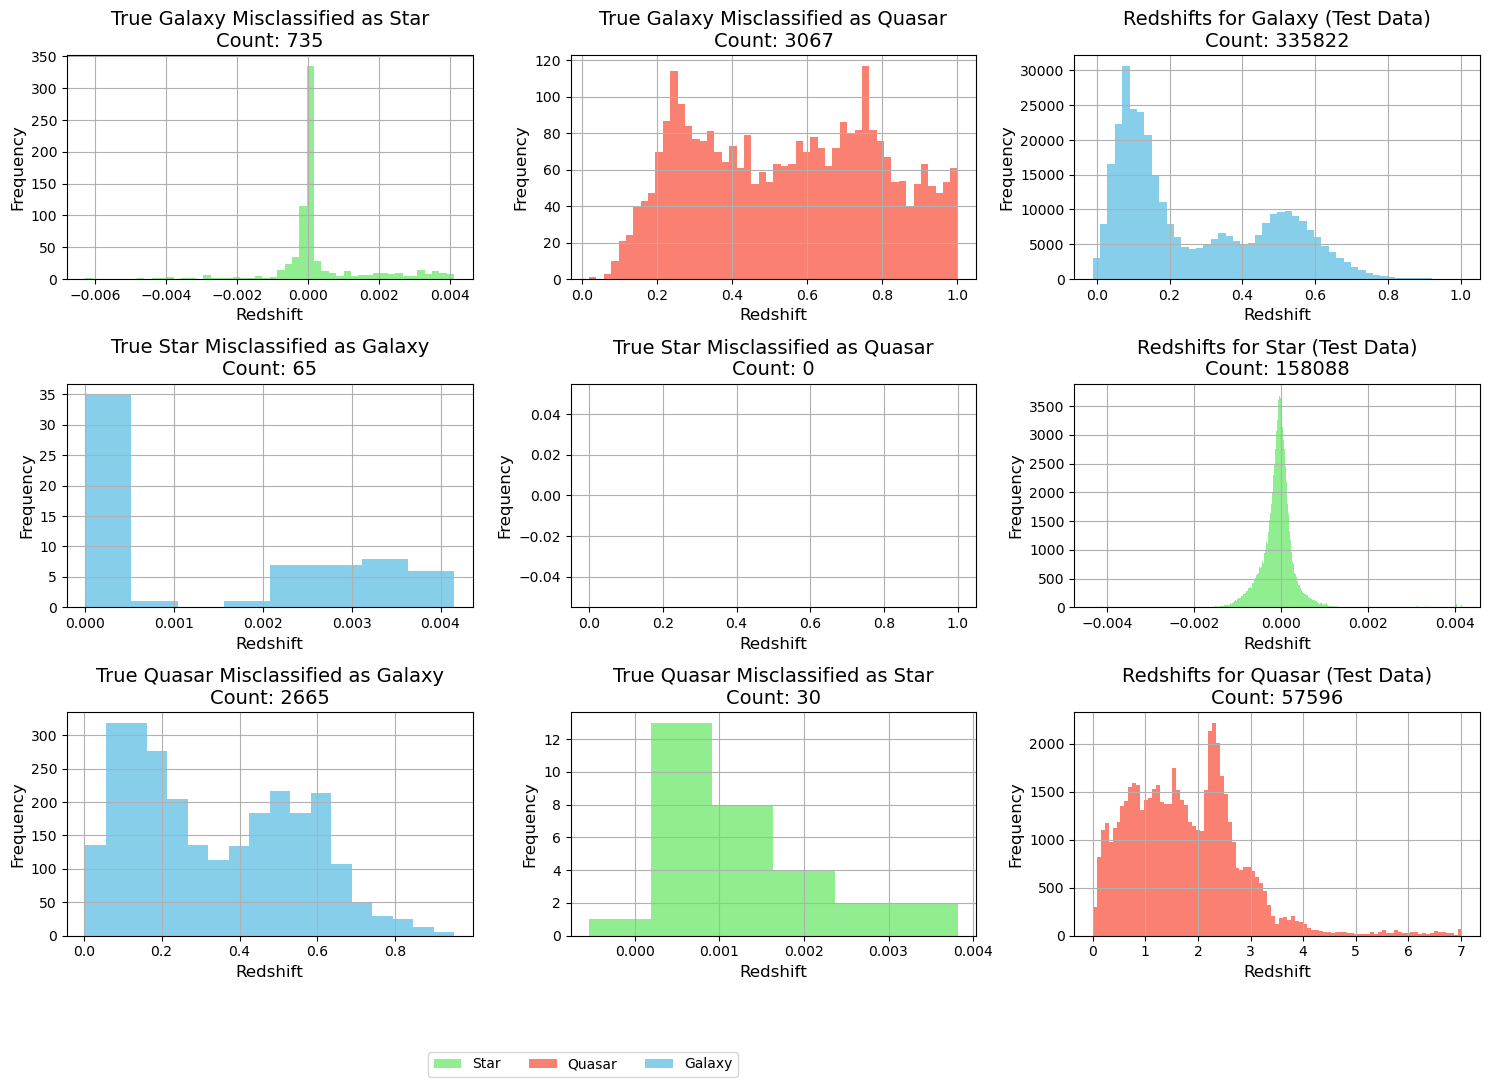

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Set custom colors
color_galaxy = 'skyblue'
color_star = 'lightgreen'
color_quasar = 'salmon'

# Plot the histogram for true_class = 0 misclassified as 1
galaxy_misclassified_as_star = mismatched_objects[(mismatched_objects['true_class'] == 0) & (mismatched_objects['predicted_class'] == 1)]
axs[0, 0].hist(galaxy_misclassified_as_star['redshift'], bins=50, color=color_star)
axs[0, 0].set_xlabel('Redshift', fontsize=12)
axs[0, 0].set_ylabel('Frequency', fontsize=12)
axs[0, 0].set_title(f'True Galaxy Misclassified as Star\nCount: {len(galaxy_misclassified_as_star)}', fontsize=14)

# Plot the histogram for true_class = 0 misclassified as 2
galaxy_misclassified_as_quasar = mismatched_objects[(mismatched_objects['true_class'] == 0) & (mismatched_objects['predicted_class'] == 2)]
axs[0, 1].hist(galaxy_misclassified_as_quasar['redshift'], bins=50, color=color_quasar)
axs[0, 1].set_xlabel('Redshift', fontsize=12)
axs[0, 1].set_ylabel('Frequency', fontsize=12)
axs[0, 1].set_title(f'True Galaxy Misclassified as Quasar\nCount: {len(galaxy_misclassified_as_quasar)}', fontsize=14)

# Plot the histogram for true_class = 0 redshift distribution from test data
galaxy_test_redshift = star_spect_df[(star_spect_df['class'] == 0) & (star_spect_df.index.isin(ys_test.index))]
axs[0, 2].hist(galaxy_test_redshift['redshift'], bins=50, color=color_galaxy)
axs[0, 2].set_xlabel('Redshift', fontsize=12)
axs[0, 2].set_ylabel('Frequency', fontsize=12)
axs[0, 2].set_title(f'Redshifts for Galaxy (Test Data)\nCount: {len(galaxy_test_redshift)}', fontsize=14)

# Plot the histogram for true_class = 1 misclassified as 0
star_misclassified_as_galaxy = mismatched_objects[(mismatched_objects['true_class'] == 1) & (mismatched_objects['predicted_class'] == 0)]
axs[1, 0].hist(star_misclassified_as_galaxy['redshift'], bins='auto', color=color_galaxy)
axs[1, 0].set_xlabel('Redshift', fontsize=12)
axs[1, 0].set_ylabel('Frequency', fontsize=12)
axs[1, 0].set_title(f'True Star Misclassified as Galaxy\nCount: {len(star_misclassified_as_galaxy)}', fontsize=14)

# Plot the histogram for true_class = 1 misclassified as 2
star_misclassified_as_quasar = mismatched_objects[(mismatched_objects['true_class'] == 1) & (mismatched_objects['predicted_class'] == 2)]
axs[1, 1].hist(star_misclassified_as_quasar['redshift'], bins='auto', color=color_quasar)
axs[1, 1].set_xlabel('Redshift', fontsize=12)
axs[1, 1].set_ylabel('Frequency', fontsize=12)
axs[1, 1].set_title(f'True Star Misclassified as Quasar\nCount: {len(star_misclassified_as_quasar)}', fontsize=14)

# Plot the histogram for true_class = 1 redshift distribution from test data
star_test_redshift = star_spect_df[(star_spect_df['class'] == 1) & (star_spect_df.index.isin(ys_test.index))]
axs[1, 2].hist(star_test_redshift['redshift'], bins='auto', color=color_star)
axs[1, 2].set_xlabel('Redshift', fontsize=12)
axs[1, 2].set_ylabel('Frequency', fontsize=12)
axs[1, 2].set_title(f'Redshifts for Star (Test Data)\nCount: {len(star_test_redshift)}', fontsize=14)

# Plot the histogram for true_class = 2 misclassified as 0
quasar_misclassified_as_galaxy = mismatched_objects[(mismatched_objects['true_class'] == 2) & (mismatched_objects['predicted_class'] == 0)]
axs[2, 0].hist(quasar_misclassified_as_galaxy['redshift'], bins='auto', color=color_galaxy)
axs[2, 0].set_xlabel('Redshift', fontsize=12)
axs[2, 0].set_ylabel('Frequency', fontsize=12)
axs[2, 0].set_title(f'True Quasar Misclassified as Galaxy\nCount: {len(quasar_misclassified_as_galaxy)}', fontsize=14)

# Plot the histogram for true_class = 2 misclassified as 1
quasar_misclassified_as_star = mismatched_objects[(mismatched_objects['true_class'] == 2) & (mismatched_objects['predicted_class'] == 1)]
axs[2, 1].hist(quasar_misclassified_as_star['redshift'], bins='auto', color=color_star)
axs[2, 1].set_xlabel('Redshift', fontsize=12)
axs[2, 1].set_ylabel('Frequency', fontsize=12)
axs[2, 1].set_title(f'True Quasar Misclassified as Star\nCount: {len(quasar_misclassified_as_star)}', fontsize=14)

# Plot the histogram for true_class = 2 redshift distribution from test data
quasar_test_redshift = star_spect_df[(star_spect_df['class'] == 2) & (star_spect_df.index.isin(ys_test.index))]
axs[2, 2].hist(quasar_test_redshift['redshift'], bins='auto', color=color_quasar)
axs[2, 2].set_xlabel('Redshift', fontsize=12)
axs[2, 2].set_ylabel('Frequency', fontsize=12)
axs[2, 2].set_title(f'Redshifts for Quasar (Test Data)\nCount: {len(quasar_test_redshift)}', fontsize=14)

# Add grid lines
for ax in axs.flat:
    ax.grid(True)

# Adjust spacing between subplots
legend_labels = ['Star', 'Quasar', 'Galaxy']
fig.legend(legend_labels, loc='upper right', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.tight_layout()

# Show the plot
plt.savefig('imgs/redshift_misclassifications_vs_distributions.png')
plt.show()


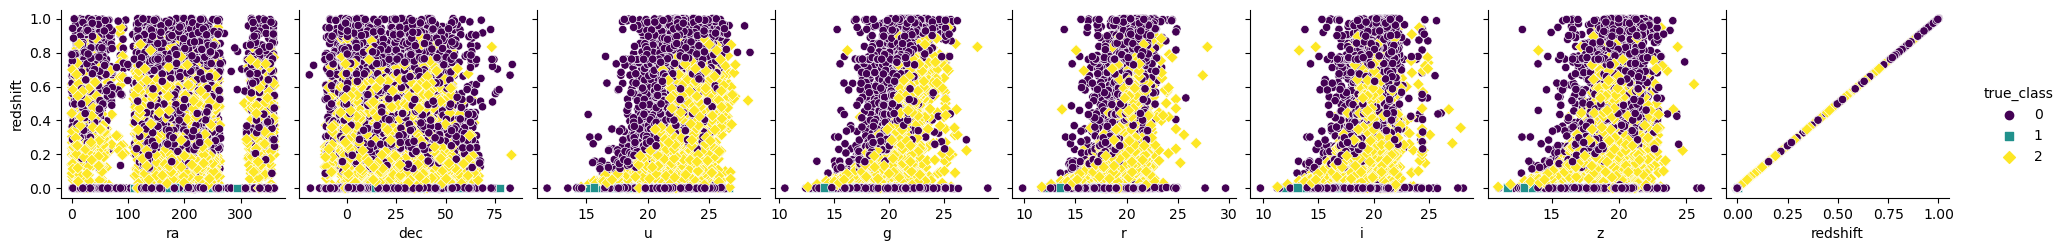

In [38]:
sns.pairplot(mismatched_objects.drop(columns=['objid','predicted_class']),y_vars=['redshift'], hue='true_class', palette='viridis',markers=["o", "s", "D"],diag_kind=None)
plt.savefig('imgs/pairplot1.png')

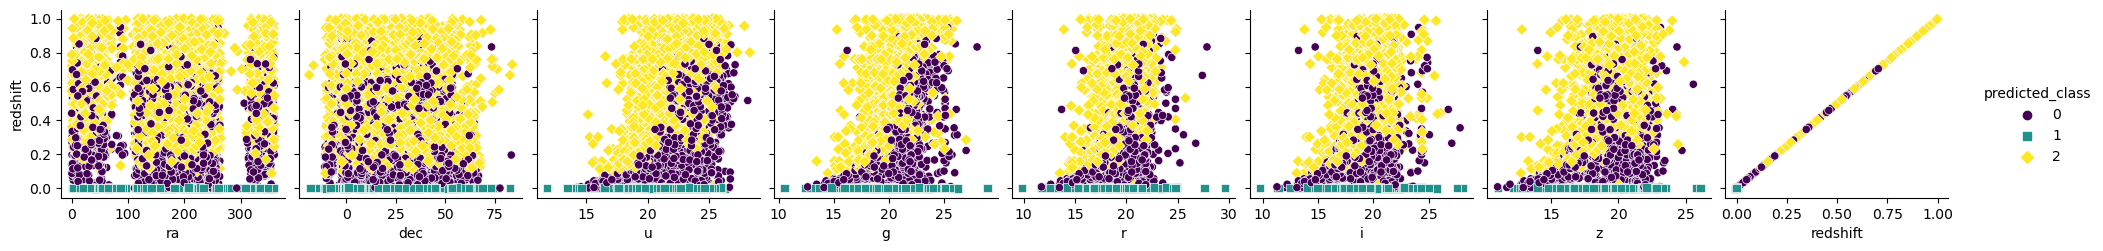

In [39]:
sns.pairplot(mismatched_objects.drop(columns=['objid','true_class']),y_vars=['redshift'], hue='predicted_class', palette='viridis',markers=["o", "s", "D"],diag_kind=None)
plt.savefig('imgs/pairplot2.png')

## Final Thoughts as of Mar 7 2024
#### There is so much more that can be done with this data. Here are some of my findings and some lingering questions:
* Without knowing any laws of physics, the model predicted the class of 551,506 stellar objects {Galaxy: 0, Star: 1, Quasar:2} correctly for 544,944 of the objects.
* I documented several objects that have a change in classification and am curious when none of the other data changes in my query except for the class, what is the root cause of that?
* Making better use of the position in the sky may prove useful when taking into account gravitational redshift and other relativistic effects.
* This is a big dataset to train and I am weary to try hyperparameter tuning in this case but it may improve the model. 
* Removing the 'objid' from the dataframe may marginally increase performance but it was useful for me to look at the real images the of the tough objects to classify
